In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.listdir())

['concatenated_results.csv', '1605T100817', '1313T030817', 'plot_bayesian_posterior.ipynb', '1608T100817', '.ipynb_checkpoints', 'DataMerge.ipynb', '1614T100817']


In [26]:
result = pd.DataFrame()
#pfile=os.path.join('1313T030817','parameters.csv')
pfile='concatenated_results.csv'
num_lines = sum(1 for line in open(pfile))
df = pd.read_csv(pfile, chunksize=10000, index_col='idx')
for chunk in df:
    #chunk.dropna(axis=0, inplace=True) # Dropping all rows with any NaN value
    chunk.fillna(100000, inplace=True)
    result = result.append(chunk)

print("Number of NaN values:\t{}".format(num_lines-sum(pd.notnull(result['euclidean']))))

Number of NaN values:	1


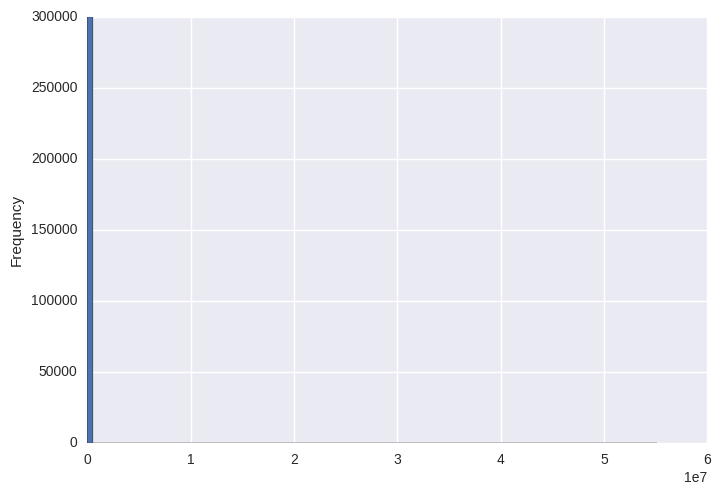

In [27]:
result['euclidean'].plot(kind='hist', bins=100)

Zoom in to distances below 200 to get a better idea of how they are distributed at the bottom end.

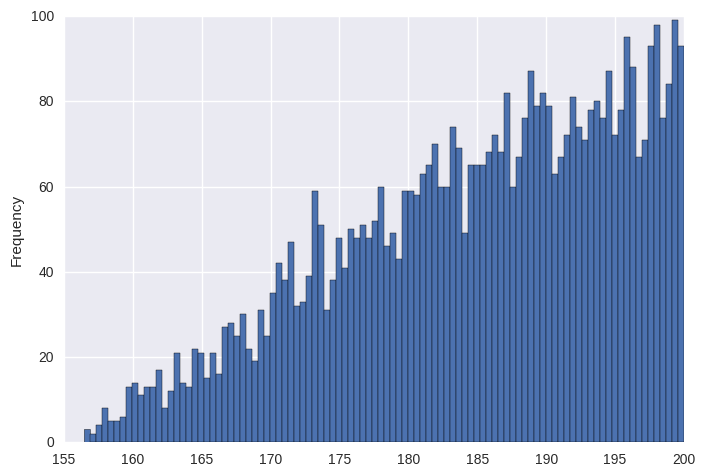

In [28]:
result[result['euclidean'] < 200]['euclidean'].plot(kind='hist', bins=100)

# Obtaining posteriors #
From the current OpenOpt framework, a distance of about 165 has been obtained as a best fit. Adding a small amount on to this to allow for the fact that 165 is not a "truly" best fit - a lower value may be possible and a slightly higher value may be considered a reasonable fit overall.

/home/buck06191/anaconda3/envs/data/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


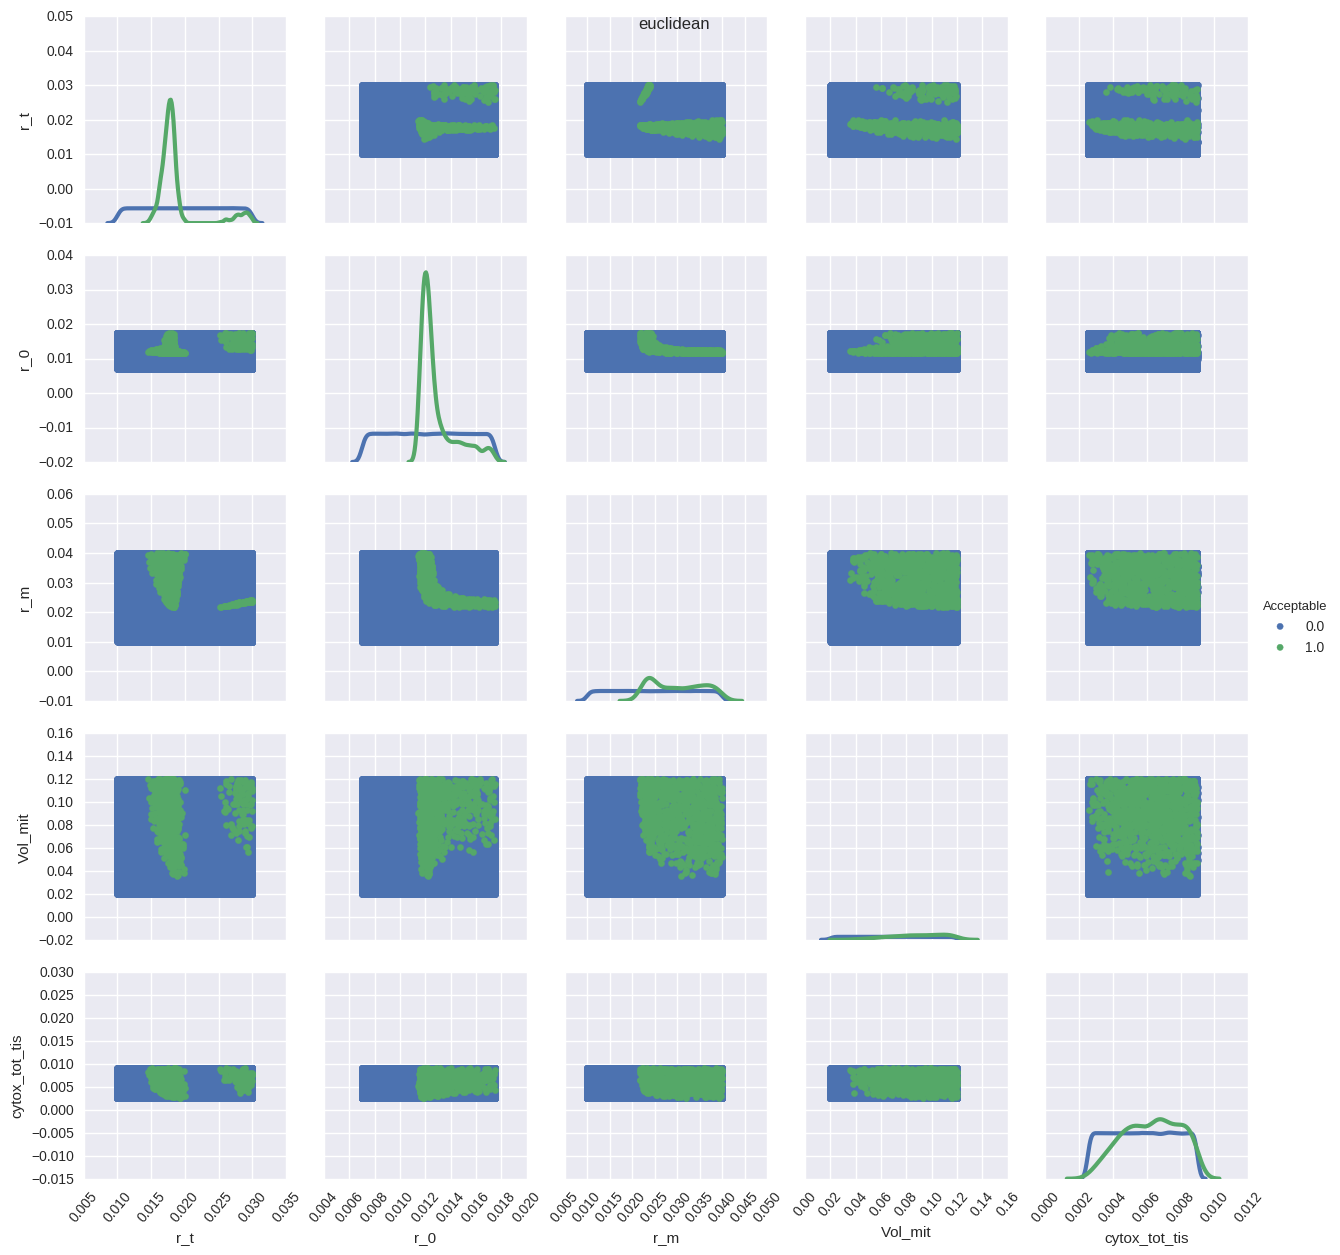

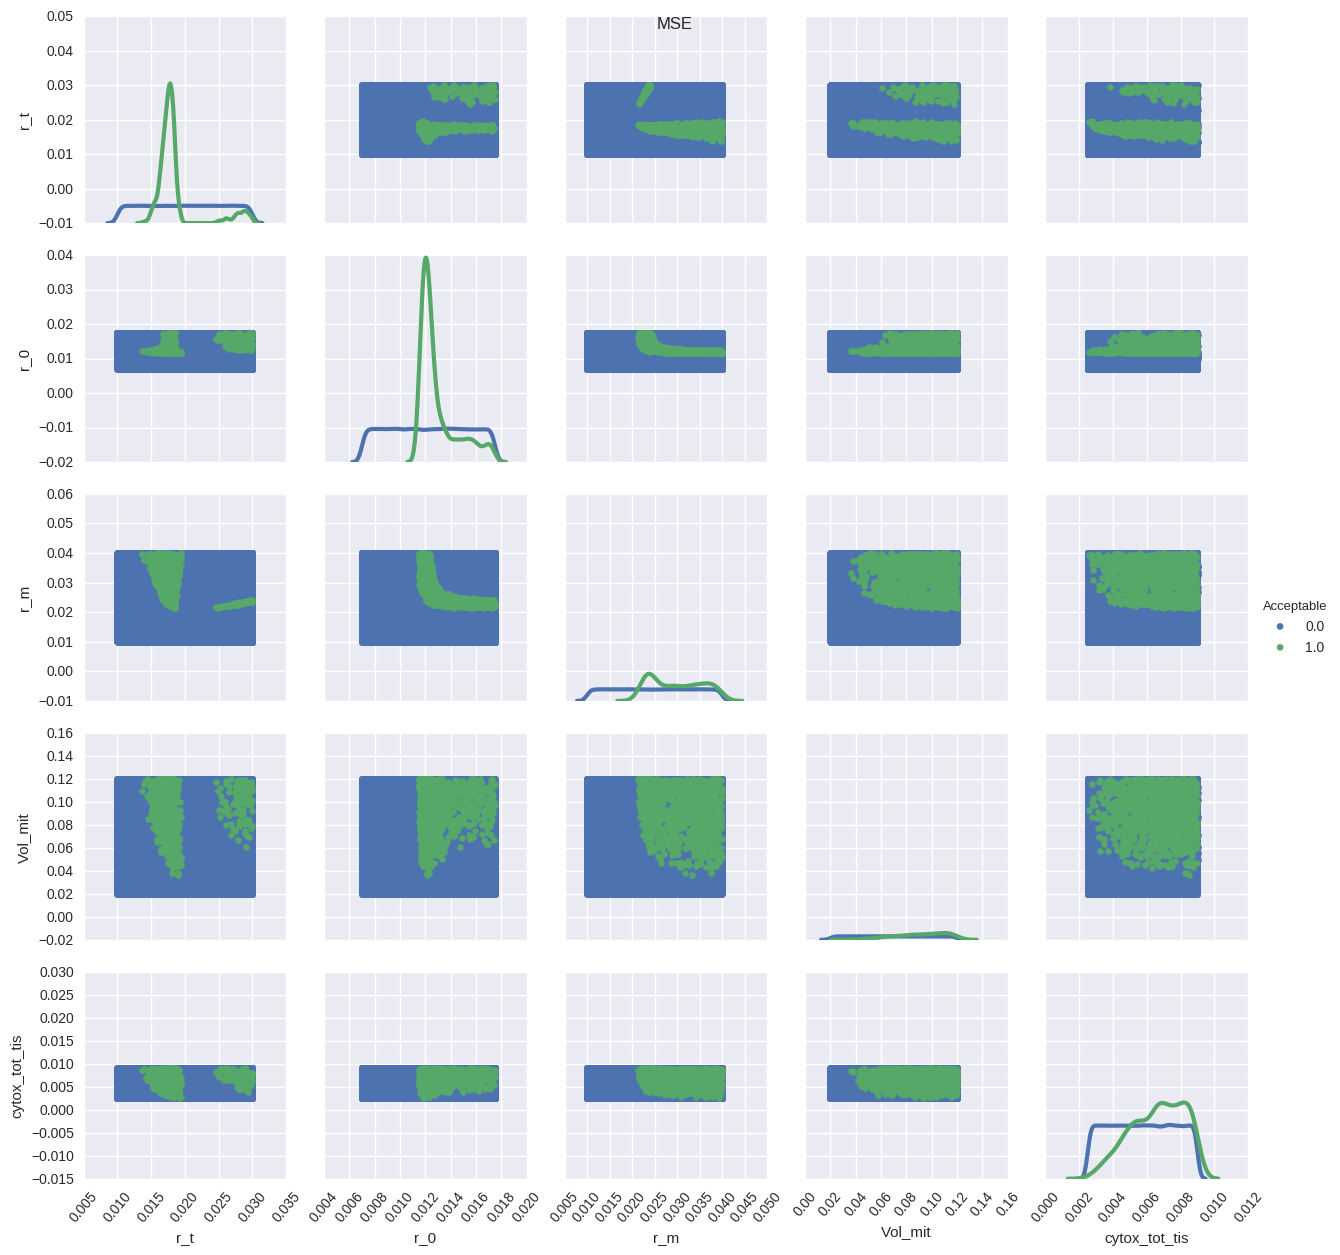

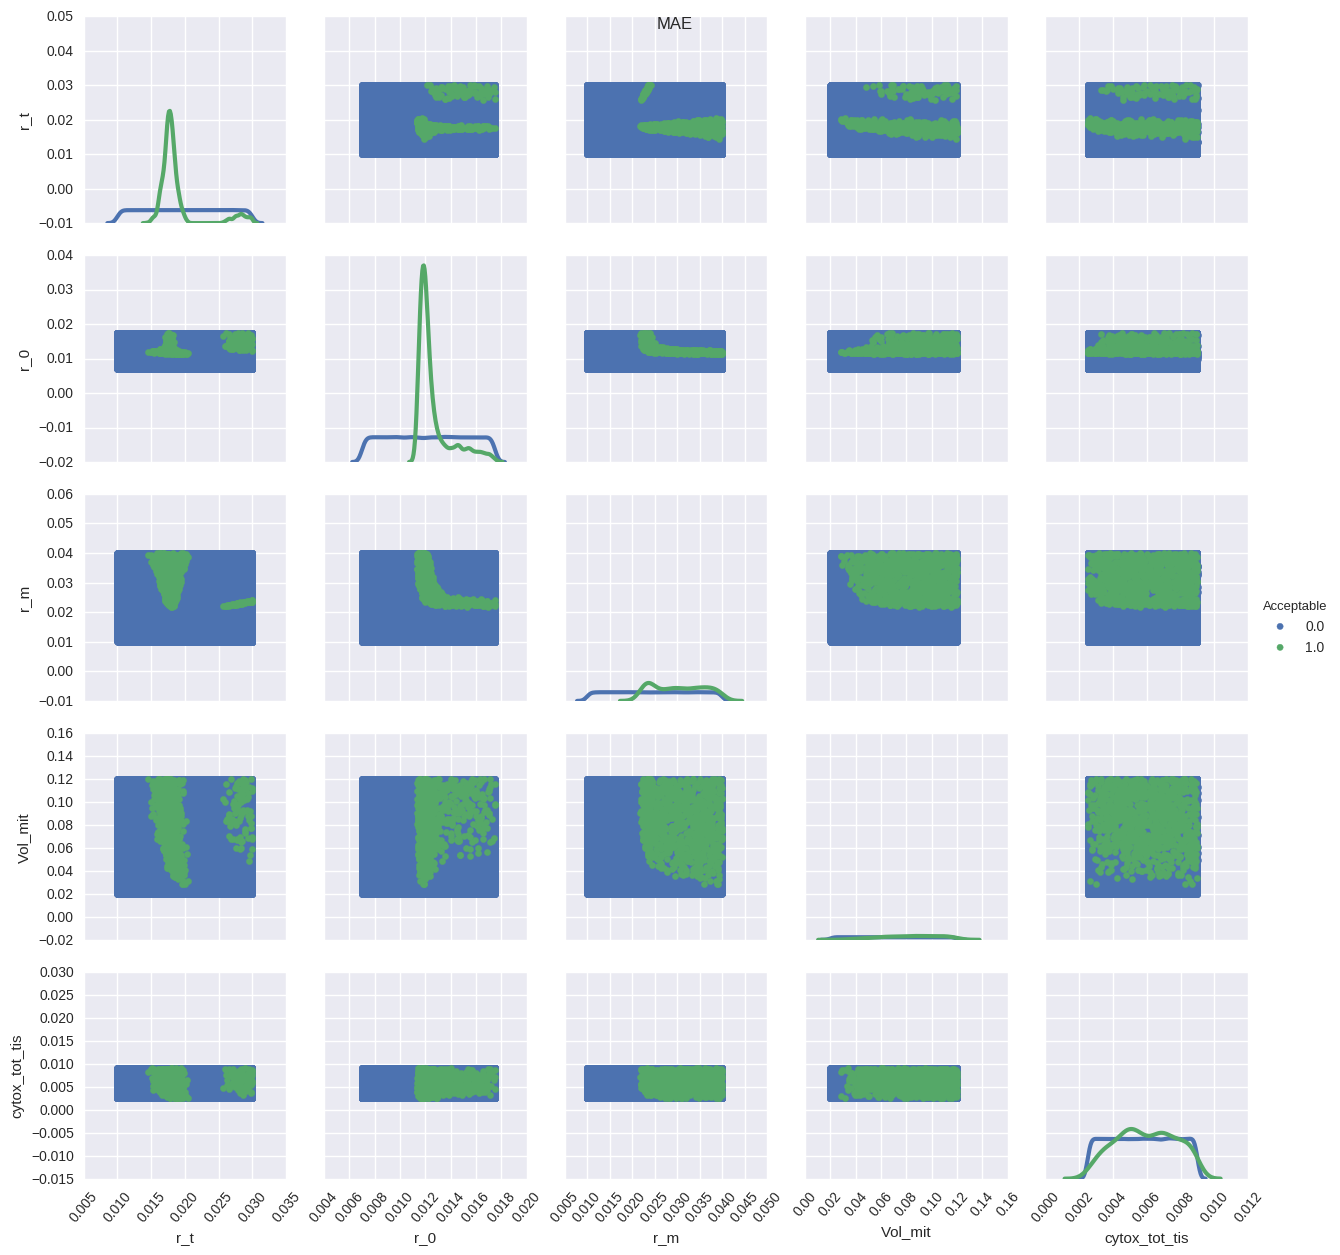

In [29]:
distances = ['euclidean','MSE', 'MAE']
for d in distances:
    plt.figure()

    result['Acceptable'] = np.zeros(len(result))
    result.sort_values(by=d, inplace=True)
    #acceptable_idx = result[d] < 175
    #result['Acceptable'].ix[acceptable_idx] = 1
    result['Acceptable'].iloc[:1000] = 1
    g = sns.PairGrid(result, vars=['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis'], hue='Acceptable')
    g.map_diag(sns.kdeplot, lw=3, legend=False)
    g.map_offdiag(plt.scatter)
    g.add_legend()
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(50)
    plt.suptitle(d)
    

/home/buck06191/anaconda3/envs/data/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


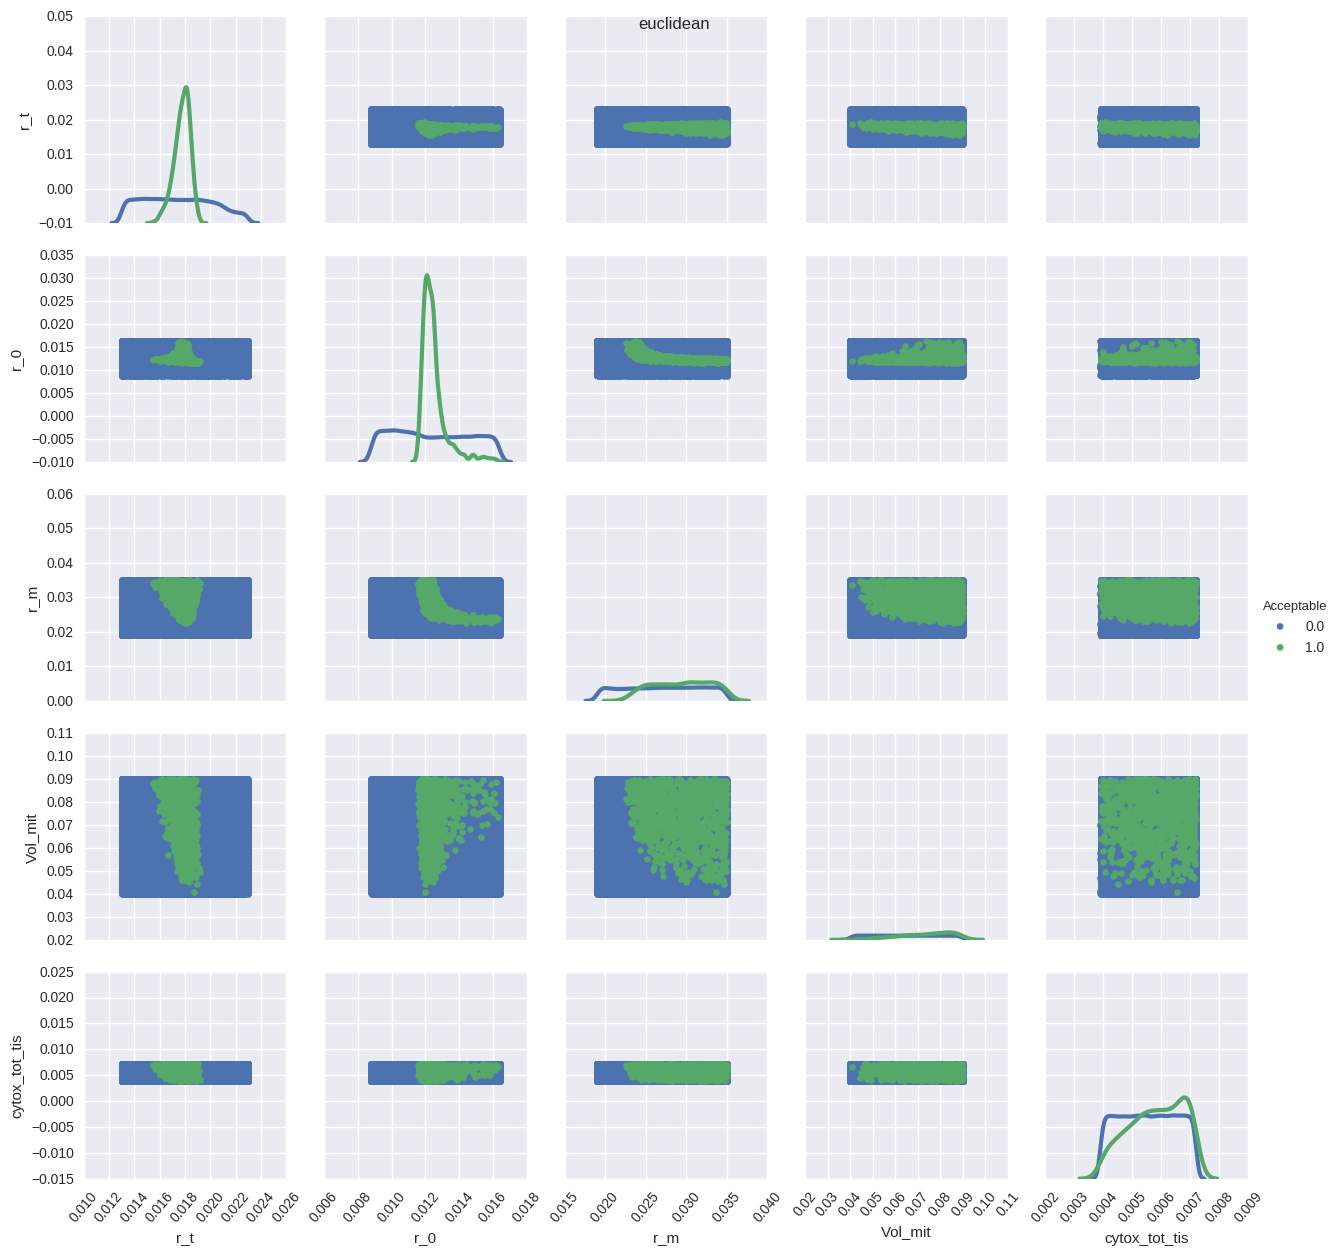

In [18]:
result['Acceptable'] = np.zeros(len(result))
result.sort_values(by=d, inplace=True)
#acceptable_idx = result['euclidean'] < 
#result.ix[acceptable_idx,'Acceptable'] = 1
result['Acceptable'].iloc[:1000] = 1
g = sns.PairGrid(result, vars=['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis'], hue='Acceptable')
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.map_offdiag(plt.scatter)
g.add_legend()
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(50)
plt.suptitle(d)